<a href="https://colab.research.google.com/github/TakafumiMatsuda/Python-Training/blob/update1/GradCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #GPU使えるかどうか調べる
print(device)

cuda:0


In [0]:
#####Loading and normalizing CIFAR10 2#####
trabsize=400
#trabsize=4
valbsize=100
tesbsize=4
# 画像の変換処理を定義する（画像をtorch.Tensorに変換し、3つあるチャネル毎に標準化（平均0.5、標準偏差0.5）する）
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10のトレーニングデータをダウンロードしtransformで変換
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) #download=True：rootの位置にデータを保存
#print(trainset.__getitem__(0)[0].shape)

n_samples = len(trainset) # n_samples is 60000
print('CIFAR10のtraindataset数: ', len(trainset)) # 50000
train_size = int(len(trainset) * 0.8) # train_size is 40000
val_size = n_samples - train_size # val_size is 10000
# shuffleしてtrainsetとvalidationsetに分割
train_splitset, valid_splitset = torch.utils.data.random_split(trainset, [train_size, val_size])
print('分割後トレーニングデータ数: ',len(train_splitset)) # 40000
print('分割後検証データ数: ',len(valid_splitset)) # 10000

# トレーニングデータの読み込み方を定義（ミニバッチに分け、エポック毎にシャッフルして再度ミニバッチを作る）（2つのサブプロセスに分けて並列処理）
trainloader = torch.utils.data.DataLoader(train_splitset, batch_size=trabsize, shuffle=False, num_workers=2) #シャッフルなしにしてる
validloader = torch.utils.data.DataLoader(valid_splitset, batch_size=valbsize, shuffle=False, num_workers=2)
# CIFAR10のテストデータをダウンロードし、transformで変換する
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# テストデータの読み込み方を定義（テストデータはシャッフルする必要なし）
testloader = torch.utils.data.DataLoader(testset, batch_size=tesbsize, shuffle=False, num_workers=2)
print('テストデータ数: ',len(testset)) # 10000

# CIFAR10のクラスラベル
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
CIFAR10のtraindataset数:  50000
分割後トレーニングデータ数:  40000
分割後検証データ数:  10000
Files already downloaded and verified
テストデータ数:  10000


In [0]:
###★★事前学習済Net★★###
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    resnet = models.resnet50(pretrained=True)
    self.resnet = nn.Sequential(*list(resnet.children())[:-2]) #Global Average Poolingを削除してresnet
    self.maxpool = nn.MaxPool2d(kernel_size=1) #Max Pooling層追加
    self.fc = nn.Linear(2048, 10) #出力を10次元に

  def forward(self,x):
    #print(x.shape) #[400, 3, 32, 32]
    x = self.resnet(x)
    #print(x.shape) #[400, 2048, 1, 1]
    x = self.maxpool(x)
    #print(x.shape) #[400, 2048, 1, 1]
    x = x.view(x.size(0), -1)
    #print(x.shape) #[400, 2048]
    x = self.fc(x)
    #print(x.shape) #[400, 10]
    return x

# resnet = nn.Sequential(*list(resnet.children())[:-3]) # 一部の層のみを使いたい場合

#net = Net() #インスタンス化している！net.forward(x)として使えるようになる
#net.to(device) #GPUに渡す

In [0]:
#####Define a Loss function and optimizer#####
import torch.optim as optim
model = Net().to(device)
criterion = nn.CrossEntropyLoss() # 損失関数: クロスエントロピー（確率的勾配降下法との相性が良いため2乗和誤差よりもよく使われる）
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #最適化アルゴリズム: SGD　#学習率: 0.001、モメンタムのパラメータ: 0.9に設定


#schedular = ExponentialLR(optimizer, gamma=0.95)
#net.parameters()がCNNの全パラメータを保持

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
###★★Train★★###
#net.train() #学習モードにする

print('トレーニングデータ数: ', len(train_splitset))
print('検証データ数: ', len(valid_splitset))
print('トレーニングデータバッチあたり数: ', len(train_splitset)/len(trainloader)) #=trabsizeになるはず
print('トレーニングデータバッチ数: ', len(trainloader)) 
running_trainloss_list=[]
running_validloss_list=[]
tacu_list=[]
vacu_list=[]
for epoch in range(1): #epochループ epoch=5なので同じデータを5回学習させることになる
    running_trainloss = 0.0 #損失関数の累積値（初期値0）
    running_validloss = 0.0 #損失関数の累積値（初期値0）
    ### ミニバッチ毎に学習をループ（インデックスは0スタート）
    for i, tdata in enumerate(trainloader, 0): #enumerate: リストの要素とインデックスを取得
        #print('ミニバッチ番号', i) #
        # ミニバッチのデータとラベルを取得
        traininputs, trainlabels = tdata[0].to(device), tdata[1].to(device) #GPUに送る

        optimizer.zero_grad() #grad(勾配)を0に初期化 #backwardメソッドでは勾配が累積されるため、バッチループ毎に勾配を初期化する
        #trainoutputs = net(traininputs) # 順伝播
        trainoutputs = model(traininputs) # 順伝播
        trainloss = criterion(trainoutputs, trainlabels) # 損失関数計算

        # 損失関数の累積値を計算
        running_trainloss += trainloss.item() # （.item()はゼロ次元テンソルから値を取り出す（loss.data[0]と書く必要がない））
        running_trainloss_list.append(running_trainloss) # 損失関数累積値のミニバッチ毎のリスト作成 # append(): リスト末尾に要素を追加

        # 10バッチ毎に損失関数の平均値を表示
        if i % 10 == 9:    # %=余り
            print('epoch: %d, batch: %5d, train_loss: %.3f' % (epoch + 1, i + 1, running_trainloss / 10)) # エポック、バッチ、損失関数のバッチ平均値の順に表示
            running_trainloss = 0.0 # 損失関数の累積値を0で初期化

        #####validデータのlossを計算する
        # ミニバッチ毎にloss計算をループ（インデックスは0スタート）

        vdata = next(iter(validloader)) # いけたあああああああああああああ
        validinputs, validlabels = vdata[0].to(device), vdata[1].to(device) # GPUに送る
        #validoutputs = net(validinputs) # 順伝播
        validoutputs = model(validinputs) # 順伝播
        validloss = criterion(validoutputs, validlabels) # 損失関数計算
        running_validloss += validloss.item() # 損失関数の累積値を計算
        running_validloss_list.append(running_validloss) # 損失関数累積値のミニバッチ毎のリスト

        # 10バッチ毎に損失関数の平均値を表示
        if i % 10 == 9:
            #print('epoch: %d, batch: %5d, valid_loss: %.3f' %(epoch + 1, i + 1, running_validloss / 10)) # エポック、バッチ、損失関数のバッチ平均値の順に表示
            running_validloss = 0.0 # 損失関数の累積値を0で初期化
        #################################
        
        # ニューラルネットを更新
        trainloss.backward() # 逆伝播
        optimizer.step() # ★★★損失関数からCNNのパラメータ（重みとバイアス）を計算して更新
        #print(net.parameters()) #パラメータ見てみる→<generator object Module.parameters at 0x7f970b7c0db0>

        #####accuracyを見る
        ttotal = 0
        tcorrect = 0
        vtotal = 0
        vcorrect = 0

        # トレーニングデータ予測
        _, tpredicted = torch.max(trainoutputs.data, 1) # trainデータセットをミニバッチ毎に予測
        ttotal += trainlabels.size(0) # 予測したデータ数を加算
        tcorrect += (tpredicted == trainlabels).sum().item() # 正解したデータ数を加算
        tacu = 100 * tcorrect / ttotal # 正解率
        tacu_list.append(tacu)

        # 検証データ予測
        _, vpredicted = torch.max(validoutputs.data, 1)
        vtotal += validlabels.size(0)
        vcorrect += (vpredicted == validlabels).sum().item()
        vacu = 100 * vcorrect / vtotal
        vacu_list.append(vacu)
        
        # 全体の正解率を表示
        #if i % 10 == 9:
          #print('Accuracy of the network on the 400 train images: %d %%' % (100 * tcorrect / ttotal))
          #print('Accuracy of the network on the 100 valid images: %d %%' % (100 * vcorrect / vtotal))
        #########################

# 学習終了のメッセージ
print('Finished Training')

#1.重みとバイアスを初期化する。
#2.以下を学習回数ぶん繰り返す。
#  2-1.以下を入力のぶん繰り返す。
#      2-1-1.現在の重みとバイアスを使い、入力データから各層の値を計算する (順伝播)。
#      2-1-2.損失関数を計算する。偏微分の計算に直接必要ではないが、学習の経過を確認できる。
#      2-1-3.損失関数に対する各層の重みとバイアスの偏微分を計算する。
#  2-2入力ごとの損失関数に対する偏微分 (∂L/∂w∂L/∂w) から、全体損失関数に対する偏微分 (∂L(all)/∂w∂L(all)/∂w) を計算する。
#  2-3.最急降下法を使い、重みとバイアスを修正する。

トレーニングデータ数:  40000
検証データ数:  10000
トレーニングデータバッチあたり数:  400.0
トレーニングデータバッチ数:  100
epoch: 1, batch:    10, train_loss: 2.330
epoch: 1, batch:    20, train_loss: 2.204
epoch: 1, batch:    30, train_loss: 2.041
epoch: 1, batch:    40, train_loss: 1.915
epoch: 1, batch:    50, train_loss: 1.761
epoch: 1, batch:    60, train_loss: 1.635
epoch: 1, batch:    70, train_loss: 1.478
epoch: 1, batch:    80, train_loss: 1.367
epoch: 1, batch:    90, train_loss: 1.288
epoch: 1, batch:   100, train_loss: 1.205
Finished Training


In [0]:
#####quickly save our trained model#####
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH) #torch.save(model名.state_dict(), PATH)でモデルを保存

In [0]:
###Grad-CAMによる可視化
import pandas as pd
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

#Flattenの実装(PyTorchには，多次元配列を1次元の配列に変換する．Flattenがないので実装)
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

#特徴設計部の最終出力 & 識別部の出力を取得
feature_fn = torch.nn.Sequential(*list(model.children())[:-1]).to(device) #Sequentialにリストを渡してやる
#print(list(model.children())[:-2]) #[:-2]: リストの最後の2つのを除いた要素（MaxPoolまで）
print(feature_fn) 

#classfier_fn = torch.nn.Sequential(*( list( model.children())[-2:-1] + [Flatten()] + list(model.children())[-1:]) ).to(device)
classfier_fn = torch.nn.Sequential(*( [Flatten()] + list(model.children())[-1:]) ).to(device)
print(classfier_fn) 



###勾配とか取り出してみる###
#i = 0
#for param in feature_fn.parameters():
#    i = i + 1
#    if i > 157:
#       print(i)
#       print(param)

#i = 0
#for param in classfier_fn.parameters():
#    i = i + 1
#    if i > 0:
#       print(i)
#       print(param)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [0]:
#GradCAM定義
def GradCam(img, c, feature_fn, classifier_fn): #(input, class label, 特徴量層, 全結合層)
    #print('img = ',img.shape) #torch.Size([1, 3, 32, 32])
    feature_fn.eval()
    classifier_fn.eval()
    feats = feature_fn(img.to(device)) #img
    _, N, H, W = feats.size()

    #print(feats.size()) #torch.Size([1, 2048, 1, 1]) = print(feats.shape)
    #print(feats.size(0)) #1
    #print(feats.view(-1,2).size()) #2列にする ([1024,2])
    #print(feats.view(-1,1).size()) #1列にする ([2048,1])
    #print(feats.view(-1,1,1,1).size())  #([2048,1,1,1])
    #print(feats.view(1,-1,1,1).size()) #([1,2048,1,1])
    #print(feats.view(feats.size(0),-1).size()) #([1,2048])
    #view: 4次元(1, 直前のoutputチャネル数, kernel, kernel)のデータを2次元(batch, output*out*ker*ker)に [1, 2048*1*1]=[1, 2048]
    out = classifier_fn(feats.view(feats.size(0), -1))
    c_score = out[0, c]
    print('c_socore=',c_score)
    grads = torch.autograd.grad(c_score, feats) #(input, output): inputに対するoutputの勾配の合計
    print('grad=',grads)
    w = grads[0][0].mean(-1).mean(-1) #全ピクセルについて平均
    sal = torch.matmul(w, feats.view(N, H*W))
    sal = F.relu(sal) #Reluを行う
    sal = sal.view(H, W).cpu().detach().numpy()
    sal = np.maximum(sal, 0)
    return sal, out, c_score, feats, grads, w

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
c_socore= tensor(2.0610, device='cuda:0', grad_fn=<SelectBackward>)
grad= (tensor([[[[ 0.0087]],

         [[-0.0029]],

         [[-0.0072]],

         ...,

         [[ 0.0148]],

         [[-0.0038]],

         [[ 0.0143]]]], device='cuda:0'),)
class_label= tensor(3, device='cuda:0')
class_label= tensor(1, device='cuda:0')
class_label= tensor(5, device='cuda:0')
class_label= tensor(4, device='cuda:0')


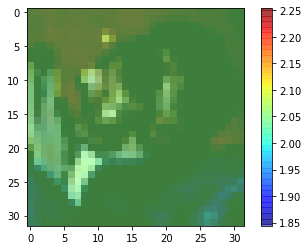

In [0]:
###GradCAMの実行
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#対象画像の取得
#i=0
#for data in testloader:
#    i=i+1
#    print('batch数='i)

#for nd in 11:
#    data = next(iter(testloader))
#    print(len(data)) #3

input_index = 0 #0~9999を指定できる（全てのテストデータ）
input_data = testloader.dataset[input_index][0]
print(len(input_data)) #3
input_data = input_data.view(1, input_data.shape[0], input_data.shape[1], input_data.shape[2]).to(device)
#print(input_data.shape[0]) #1
#print(input_data.shape[1]) #3
#print(input_data.shape[2]) #32
#print(input_data.__getitem__(0)[0].shape) #[32, 32]
#print(len(input_data)) #1

model.eval()
#上位10クラスの識別部の出力 & クラスラベルを取得
pp, cc = torch.topk(nn.Softmax(dim=1)(model(input_data)), 10) 
#topk()は，上位kクラスのデータとクラスラベルを取得する関数
#pp → CNNモデルの出力層の出力
#cc → それに対応するクラスラベル

#print('pp=',pp) #[0.9843, 0.0116]
#print('cc=',cc) #[8,0]
#print(cc[0])
#print(cc[0][0]) #8

#saliency mapの取得
sal, out, c_score, feats, grads, w = GradCam(input_data, cc[0][0], feature_fn, classfier_fn)
print('class_label=',cc[0][0])
print('class_label=',cc[0][1])
print('class_label=',cc[0][2])
print('class_label=',cc[0][9])
#sal → cc[0][0]で指定したクラスラベルにおける勾配のSaliency Map
#cc[0][0]

#取得したSaliency Mapを画像化
img = input_data.permute(0, 2, 3, 1).view(input_data.shape[2], input_data.shape[3], input_data.shape[1]).cpu().numpy()
img_sal = Image.fromarray(sal).resize(img.shape[0:2], resample=Image.LINEAR)

#表示
plt.imshow(img)
plt.imshow(np.array(img_sal), alpha=0.5, cmap="jet")
plt.colorbar()